In [1]:
import datetime as dt
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Proj
#from google.colab import files

In [2]:
def get_goes_dataset(year, month, day, hour, product="ABI-L2-CMIPF", sat="goes-east", band="12"):
    date = dt.datetime(year, month, day)
    jday = date.timetuple().tm_yday

    syr = str(year).zfill(4)
    sjd = str(jday).zfill(3)
    shr = str(hour).zfill(2)

    fs = s3fs.S3FileSystem(anon=True)

    if sat == "goes-east":
      files = fs.glob(f"s3://noaa-goes16/{product}/{syr}/{sjd}/{shr}/*C{band}*.nc")
    else:
      files = fs.glob(f"s3://noaa-goes17/{product}/{syr}/{sjd}/{shr}/*C{band}*.nc")

    if len(files) == 0:
        raise ValueError("No GOES files found. Check date/hour/band.")

    print(f"Found {len(files)} files for {year}-{month}-{day} {hour}Z, Band {band}")

    file_objs = [fs.open(f) for f in files]
    ds = xr.open_mfdataset(file_objs, combine="nested", concat_dim="time")

    ds = ds.rename({"t": "time"}).reset_coords()

    return ds

In [114]:
def add_lat_lon(ds):
    p = ds.goes_imager_projection
    h = p.perspective_point_height + p.semi_major_axis
    lon_0 = p.longitude_of_projection_origin
    sweep = p.sweep_angle_axis
    a = p.semi_major_axis
    b = p.semi_minor_axis

    proj = Proj(proj="geos", h=h, lon_0=lon_0, sweep=sweep, a=a, b=b)

    X, Y = np.meshgrid(ds['x'].values, ds['y'].values)
    lon, lat = proj(X * h, Y * h, inverse=True)
    lon = np.where(np.isfinite(lon), lon, np.nan)
    lat = np.where(np.isfinite(lat), lat, np.nan)

    ds = ds.assign_coords(
        lon=(("y", "x"), lon),
        lat=(("y", "x"), lat)
    )
    return ds

In [112]:
def trim_region(data, min_lat=18, max_lat=40, min_lon=-102, max_lon=-83):
    # subset = data.where(
    #     (data.lat > min_lat) & (data.lat < max_lat) &
    #     (data.lon > min_lon) & (data.lon < max_lon)
    # )
    subset = data.where(
        np.isfinite(data.lat) & np.isfinite(data.lon) &
        (data.lat > min_lat) & (data.lat < max_lat) &
        (data.lon > min_lon) & (data.lon < max_lon)
    )   

    mask = ~np.isnan(subset.values)
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]

    trimmed = subset.isel(
        y=slice(rows.min(), rows.max()),
        x=slice(cols.min(), cols.max())
    )
    return trimmed

In [107]:
def plot_hurricane(data, title="Hurricane Image"):
    plt.figure(figsize=(8, 8))

    lon = np.asarray(data.lon)
    lat = np.asarray(data.lat)
    vals = np.asarray(data)

    plt.pcolormesh(
        lon, lat, vals,
        cmap="inferno", shading="auto"
    )
    plt.colorbar(label="Brightness Temperature (K)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()

In [6]:
def export_csv(data, filename="output.csv"):
    df = data.to_dataframe(name="CMI").reset_index()
    df = df.dropna(subset=["CMI"])
    df.to_csv(filename, index=False)
    #files.download(filename)
    return df

In [ ]:
ds = get_goes_dataset(
    year=2021, month=8, day=29, hour=14,
    band="12", product="ABI-L2-CMIPF", sat="goes-east"
)


ds = add_lat_lon(ds)

ida = ds.CMI.isel(time=0)

ida_trim = trim_region(ida)

plot_hurricane(ida_trim, title="Hurricane Ida — GOES-16 Band 13")
#export_csv(ida_trim, "ida_trim.csv")

In [ ]:
timestamps = [
    (2021, 8, 28, 6),
    (2021, 8, 28, 9),
    (2021, 8, 28, 12),
    (2021, 8, 28, 15),
    (2021, 8, 28, 18),
    (2021, 8, 28, 21),

    (2021, 8, 29, 0),
    (2021, 8, 29, 3),
    (2021, 8, 29, 6),
    (2021, 8, 29, 9),
    (2021, 8, 29, 12),
    (2021, 8, 29, 15),
    (2021, 8, 29, 18),
    (2021, 8, 29, 21),

    (2021, 8, 30, 0),
    (2021, 8, 30, 3)
]

for i, (yr, mo, dy, hr) in enumerate(timestamps):
    print(f"\n=== Processing Frame {i+1}/16 — {yr}-{mo}-{dy} {hr}Z ===")

    ds = get_goes_dataset(
        year=yr, month=mo, day=dy, hour=hr,
        band="12", product="ABI-L2-CMIPF", sat="goes-east"
    )
    ds = add_lat_lon(ds)
    data = ds.CMI.isel(time=0)
    trimmed = trim_region(data)
    filename = f"ida_{yr}{mo:02d}{dy:02d}_{hr:02d}Z.csv"
    export_csv(trimmed, filename)
    print(f"Completed frame {i+1}/16.")
print("All 16 frames processed and exported!")

In [ ]:
import pandas as pd
import numpy as np
import json
import glob
import os
import datetime as dt
from pyproj import Proj

In [1]:
import pandas as pd
import numpy as np
import os

IDA_FILES = [
  'ida_cloudprops_bt_20210828_06Z.csv', 'ida_cloudprops_bt_20210828_09Z.csv', 'ida_cloudprops_bt_20210828_12Z.csv', 
  'ida_cloudprops_bt_20210828_15Z.csv', 'ida_cloudprops_bt_20210828_18Z.csv', 'ida_cloudprops_bt_20210828_21Z.csv',
  'ida_cloudprops_bt_20210829_00Z.csv', 'ida_cloudprops_bt_20210829_03Z.csv', 'ida_cloudprops_bt_20210829_06Z.csv', 
  'ida_cloudprops_bt_20210829_09Z.csv', 'ida_cloudprops_bt_20210829_12Z.csv', 'ida_cloudprops_bt_20210829_15Z.csv', 
  'ida_cloudprops_bt_20210829_18Z.csv', 'ida_cloudprops_bt_20210829_21Z.csv', 'ida_cloudprops_bt_20210830_00Z.csv', 
  'ida_cloudprops_bt_20210830_03Z.csv'
]

In [2]:

# Sampling factor: Keep 1 out of every N points
N = 3

print(f"Starting uniform sampling: keeping 1 out of every {N} points...")

for file_name in IDA_FILES:
    if not os.path.exists(file_name):
        print(f"Skipping {file_name}: File not found.")
        continue

    df = pd.read_csv(file_name)
    
    # Downsampling by selecting every Nth row (maintains original data values)
    downsampled_df = df.iloc[::N].copy()

    # Save the new file with a '_sampled' suffix
    new_file_name = file_name.replace('.csv', f'_sampled.csv')
    downsampled_df.to_csv(new_file_name, index=False)
    
    print(f"  -> Saved as {new_file_name} with {len(downsampled_df):,} rows (original: {len(df):,}).")

Starting uniform sampling: keeping 1 out of every 3 points...
  -> Saved as ida_cloudprops_bt_20210828_06Z_sampled.csv with 201,617 rows (original: 604,849).
  -> Saved as ida_cloudprops_bt_20210828_09Z_sampled.csv with 201,424 rows (original: 604,270).
  -> Saved as ida_cloudprops_bt_20210828_12Z_sampled.csv with 201,383 rows (original: 604,147).
  -> Saved as ida_cloudprops_bt_20210828_15Z_sampled.csv with 201,974 rows (original: 605,920).
  -> Saved as ida_cloudprops_bt_20210828_18Z_sampled.csv with 202,260 rows (original: 606,778).
  -> Saved as ida_cloudprops_bt_20210828_21Z_sampled.csv with 202,078 rows (original: 606,233).
  -> Saved as ida_cloudprops_bt_20210829_00Z_sampled.csv with 201,904 rows (original: 605,711).
  -> Saved as ida_cloudprops_bt_20210829_03Z_sampled.csv with 201,782 rows (original: 605,345).
  -> Saved as ida_cloudprops_bt_20210829_06Z_sampled.csv with 201,622 rows (original: 604,864).
  -> Saved as ida_cloudprops_bt_20210829_09Z_sampled.csv with 201,567 rows

Found 4 files for 2017-9-6 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

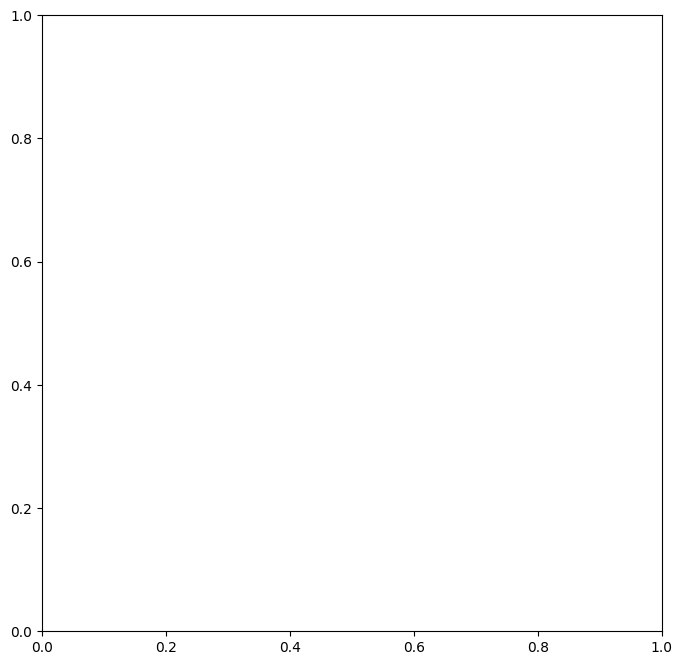

In [115]:
ds = get_goes_dataset(
    year=2017, month=9, day=6, hour=6,
    band="12", product="ABI-L2-CMIPF", sat="goes-east"
)

ds = add_lat_lon(ds)

irma = ds.CMI.isel(time=0)

irma_trim = trim_region(irma, -2, 20, -36, -26)

plot_hurricane(irma_trim, title="Hurricane Irma — GOES-16 Band 13")



In [109]:
np.isnan(irma_trim.lon).any(), np.isnan(irma_trim.lat).any(), np.isnan(irma_trim).any()

(<xarray.DataArray 'lon' ()> Size: 1B
 array(False)
 Coordinates:
     time     datetime64[ns] 8B 2017-09-06T06:05:53.715697984,
 <xarray.DataArray 'lat' ()> Size: 1B
 array(False)
 Coordinates:
     time     datetime64[ns] 8B 2017-09-06T06:05:53.715697984,
 <xarray.DataArray 'CMI' ()> Size: 1B
 dask.array<any-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
 Coordinates:
     time     datetime64[ns] 8B 2017-09-06T06:05:53.715697984)

In [110]:
irma_trim.lon
irma_trim.lat

<xarray.DataArray 'lat' (y: 947, x: 314)> Size: 2MB
array([[19.98821138, 19.99014709, 19.99208739, ...,         inf,
                inf,         inf],
       [19.96307436, 19.96500592, 19.96694205, ...,         inf,
                inf,         inf],
       [19.93794183, 19.93986925, 19.94180122, ...,         inf,
                inf,         inf],
       ...,
       [-1.89533267, -1.89546843, -1.89560441, ..., -1.95537724,
        -1.95567294, -1.95596993],
       [-1.91777665, -1.91791403, -1.91805163, ..., -1.97853793,
        -1.97883718, -1.97913773],
       [-1.94022115, -1.94036014, -1.94049937, ..., -2.00169936,
        -2.00200216, -2.00230628]], shape=(947, 314))
Coordinates:
  * y        (y) float32 4kB 0.04813 0.04808 0.04802 ... -0.004788 -0.004844
  * x        (x) float32 1kB 0.1067 0.1067 0.1068 ... 0.1241 0.1241 0.1242
    time     datetime64[ns] 8B 2017-09-06T06:05:53.715697984
    lon      (y, x) float64 2MB -35.99 -35.94 -35.89 ... -26.15 -26.08 -26.01
    lat      (y, x) float64 2MB 19.99 19.99 19.99 19.99 ... -2.002 -2.002 -2.002

In [7]:
import pandas as pd
import numpy as np
import os

In [15]:
timestamps = [
    (2017, 8, 24, 12),
    (2017, 8, 24, 18),

    (2017, 8, 25, 0),
    (2017, 8, 25, 3),
    (2017, 8, 25, 6),
    (2017, 8, 25, 9),
    (2017, 8, 25, 12),
    (2017, 8, 25, 15),
    (2017, 8, 25, 18),
    (2017, 8, 25, 21),

    (2017, 8, 26, 0),
    (2017, 8, 26, 3),
    (2017, 8, 26, 6),
    (2017, 8, 26, 9),
    (2017, 8, 26, 12),
    (2017, 8, 26, 15)
]
for i, (yr, mo, dy, hr) in enumerate(timestamps):
    print(f"\n=== Processing Frame {i+1}/16 — {yr}-{mo}-{dy} {hr}Z ===")

    ds = get_goes_dataset(
        year=yr, month=mo, day=dy, hour=hr,
        band="12", product="ABI-L2-CMIPF", sat="goes-east"
    )
    ds = add_lat_lon(ds)
    data = ds.CMI.isel(time=0)
    trimmed = trim_region(data, 24, 46, -104, -85)
    filename = f"harvey_{yr}{mo:02d}{dy:02d}_{hr:02d}Z.csv"
    export_csv(trimmed, filename)
    print(f"Completed frame {i+1}/16.")
print("All 16 frames processed and exported!")


=== Processing Frame 1/16 — 2017-8-24 12Z ===
Found 3 files for 2017-8-24 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 1/16.

=== Processing Frame 2/16 — 2017-8-24 18Z ===
Found 4 files for 2017-8-24 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 2/16.

=== Processing Frame 3/16 — 2017-8-25 0Z ===
Found 4 files for 2017-8-25 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 3/16.

=== Processing Frame 4/16 — 2017-8-25 3Z ===
Found 4 files for 2017-8-25 3Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 4/16.

=== Processing Frame 5/16 — 2017-8-25 6Z ===
Found 4 files for 2017-8-25 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 5/16.

=== Processing Frame 6/16 — 2017-8-25 9Z ===
Found 4 files for 2017-8-25 9Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 6/16.

=== Processing Frame 7/16 — 2017-8-25 12Z ===
Found 4 files for 2017-8-25 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 7/16.

=== Processing Frame 8/16 — 2017-8-25 15Z ===
Found 4 files for 2017-8-25 15Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 8/16.

=== Processing Frame 9/16 — 2017-8-25 18Z ===
Found 4 files for 2017-8-25 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 9/16.

=== Processing Frame 10/16 — 2017-8-25 21Z ===
Found 4 files for 2017-8-25 21Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 10/16.

=== Processing Frame 11/16 — 2017-8-26 0Z ===
Found 4 files for 2017-8-26 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 11/16.

=== Processing Frame 12/16 — 2017-8-26 3Z ===
Found 4 files for 2017-8-26 3Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 12/16.

=== Processing Frame 13/16 — 2017-8-26 6Z ===
Found 4 files for 2017-8-26 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 13/16.

=== Processing Frame 14/16 — 2017-8-26 9Z ===
Found 4 files for 2017-8-26 9Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 14/16.

=== Processing Frame 15/16 — 2017-8-26 12Z ===
Found 4 files for 2017-8-26 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 15/16.

=== Processing Frame 16/16 — 2017-8-26 15Z ===
Found 4 files for 2017-8-26 15Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 16/16.
All 16 frames processed and exported!


In [ ]:
HARVEY_FILES = [
  'raw_data/harvey_20170824_12Z.csv', 'raw_data/harvey_20170824_18Z.csv', 'raw_data/harvey_20170825_00Z.csv', 
  'raw_data/harvey_20170825_03Z.csv', 'raw_data/harvey_20170825_06Z.csv', 'raw_data/harvey_20170825_09Z.csv',
  'raw_data/harvey_20170825_12Z.csv', 'raw_data/harvey_20170825_15Z.csv', 'raw_data/harvey_20170825_18Z.csv', 
  'raw_data/harvey_20170825_21Z.csv', 'raw_data/harvey_20170826_00Z.csv', 'raw_data/harvey_20170826_03Z.csv', 
  'raw_data/harvey_20170826_06Z.csv', 'raw_data/harvey_20170826_09Z.csv', 'raw_data/harvey_20170826_12Z.csv', 
  'raw_data/harvey_20170826_15Z.csv'
]

# Sampling factor: Keep 1 out of every N points
N = 3

print(f"Starting uniform sampling: keeping 1 out of every {N} points...")

for file_name in HARVEY_FILES:
    if not os.path.exists(file_name):
        print(f"Skipping {file_name}: File not found.")
        continue

    df = pd.read_csv(file_name)
    
    # Downsampling by selecting every Nth row (maintains original data values)
    downsampled_df = df.iloc[::N].copy()

    # Save the new file with a '_sampled' suffix
    new_file_name = file_name.replace('.csv', f'_sampled.csv')
    downsampled_df.to_csv(new_file_name, index=False)
    
    print(f"  -> Saved as {new_file_name} with {len(downsampled_df):,} rows (original: {len(df):,}).")

Starting uniform sampling: keeping 1 out of every 3 points...
  -> Saved as raw_data/harvey_20170824_12Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170824_18Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170825_00Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170825_03Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170825_06Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170825_09Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170825_12Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170825_15Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170825_18Z_sampled.csv with 180,041 rows (original: 540,123).
  -> Saved as raw_data/harvey_20170825_21Z_sampled.csv with 180,041 rows (original: 540,123)

In [ ]:
timestamps = [
    (2022, 9, 26, 12),
    (2022, 9, 26, 18),

    (2022, 9, 27, 0),
    (2022, 9, 27, 6),
    (2022, 9, 27, 12),
    (2022, 9, 27, 18),

    (2022, 9, 28, 0),
    (2022, 9, 28, 3),
    (2022, 9, 28, 6),
    (2022, 9, 28, 9),
    (2022, 9, 28, 12),
    (2022, 9, 28, 15),
    (2022, 9, 28, 18),
    (2022, 9, 28, 21),
    
    (2022, 9, 29, 0),
    (2022, 9, 29, 6),
]
for i, (yr, mo, dy, hr) in enumerate(timestamps):
    print(f"\n=== Processing Frame {i+1}/16 — {yr}-{mo}-{dy} {hr}Z ===")

    ds = get_goes_dataset(
        year=yr, month=mo, day=dy, hour=hr,
        band="12", product="ABI-L2-CMIPF", sat="goes-east"
    )
    ds = add_lat_lon(ds)
    data = ds.CMI.isel(time=0)
    trimmed = trim_region(data, 18, 40, -90, -71)
    filename = f"ian_{yr}{mo:02d}{dy:02d}_{hr:02d}Z.csv"
    export_csv(trimmed, filename)
    print(f"Completed frame {i+1}/16.")
print("All 16 frames processed and exported!")

In [ ]:
IAN_FILES = [
  'raw_data/ian_20220926_12Z.csv', 'raw_data/ian_20220926_18Z.csv', 'raw_data/ian_20220927_00Z.csv', 
  'raw_data/ian_20220927_06Z.csv', 'raw_data/ian_20220927_12Z.csv', 'raw_data/ian_20220927_18Z.csv',
  'raw_data/ian_20220928_00Z.csv', 'raw_data/ian_20220928_03Z.csv', 'raw_data/ian_20220928_06Z.csv', 
  'raw_data/ian_20220928_09Z.csv', 'raw_data/ian_20220928_12Z.csv', 'raw_data/ian_20220928_15Z.csv', 
  'raw_data/ian_20220928_18Z.csv', 'raw_data/ian_20220928_21Z.csv', 'raw_data/ian_20220929_00Z.csv', 
  'raw_data/ian_20220929_06Z.csv'
]

# Sampling factor: Keep 1 out of every N points
N = 3

print(f"Starting uniform sampling: keeping 1 out of every {N} points...")

for file_name in IAN_FILES:
    if not os.path.exists(file_name):
        print(f"Skipping {file_name}: File not found.")
        continue

    df = pd.read_csv(file_name)
    
    # Downsampling by selecting every Nth row (maintains original data values)
    downsampled_df = df.iloc[::N].copy()

    # Save the new file with a '_sampled' suffix
    new_file_name = file_name.replace('.csv', f'_sampled.csv')
    downsampled_df.to_csv(new_file_name, index=False)
    
    print(f"  -> Saved as {new_file_name} with {len(downsampled_df):,} rows (original: {len(df):,}).")

In [116]:
timestamps = [
    (2017, 9, 5, 0),
    (2017, 9, 5, 6),
    (2017, 9, 5, 12),
    (2017, 9, 5, 18),

    (2017, 9, 6, 0),
    (2017, 9, 6, 6),
    (2017, 9, 6, 12),
    (2017, 9, 6, 18),

    (2017, 9, 7, 0),
    (2017, 9, 7, 6),
    (2017, 9, 7, 12),
    (2017, 9, 7, 18),

    (2017, 9, 8, 0),
    (2017, 9, 8, 6),
    (2017, 9, 8, 12),
    (2017, 9, 8, 18)
]
for i, (yr, mo, dy, hr) in enumerate(timestamps):
    print(f"\n=== Processing Frame {i+1}/16 — {yr}-{mo}-{dy} {hr}Z ===")

    ds = get_goes_dataset(
        year=yr, month=mo, day=dy, hour=hr,
        band="12", product="ABI-L2-CMIPF", sat="goes-east"
    )
    ds = add_lat_lon(ds)
    data = ds.CMI.isel(time=0)
    trimmed = trim_region(data, 12, 30, -80, -60)
    filename = f"irma_{yr}{mo:02d}{dy:02d}_{hr:02d}Z.csv"
    export_csv(trimmed, filename)
    print(f"Completed frame {i+1}/16.")
print("All 16 frames processed and exported!")


=== Processing Frame 1/16 — 2017-9-5 0Z ===
Found 4 files for 2017-9-5 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 1/16.

=== Processing Frame 2/16 — 2017-9-5 6Z ===
Found 4 files for 2017-9-5 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 2/16.

=== Processing Frame 3/16 — 2017-9-5 12Z ===
Found 4 files for 2017-9-5 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 3/16.

=== Processing Frame 4/16 — 2017-9-5 18Z ===
Found 4 files for 2017-9-5 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 4/16.

=== Processing Frame 5/16 — 2017-9-6 0Z ===
Found 4 files for 2017-9-6 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 5/16.

=== Processing Frame 6/16 — 2017-9-6 6Z ===
Found 4 files for 2017-9-6 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 6/16.

=== Processing Frame 7/16 — 2017-9-6 12Z ===
Found 4 files for 2017-9-6 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 7/16.

=== Processing Frame 8/16 — 2017-9-6 18Z ===
Found 4 files for 2017-9-6 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 8/16.

=== Processing Frame 9/16 — 2017-9-7 0Z ===
Found 4 files for 2017-9-7 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 9/16.

=== Processing Frame 10/16 — 2017-9-7 6Z ===
Found 4 files for 2017-9-7 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 10/16.

=== Processing Frame 11/16 — 2017-9-7 12Z ===
Found 4 files for 2017-9-7 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 11/16.

=== Processing Frame 12/16 — 2017-9-7 18Z ===
Found 4 files for 2017-9-7 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 12/16.

=== Processing Frame 13/16 — 2017-9-8 0Z ===
Found 4 files for 2017-9-8 0Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 13/16.

=== Processing Frame 14/16 — 2017-9-8 6Z ===
Found 4 files for 2017-9-8 6Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 14/16.

=== Processing Frame 15/16 — 2017-9-8 12Z ===
Found 4 files for 2017-9-8 12Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 15/16.

=== Processing Frame 16/16 — 2017-9-8 18Z ===
Found 4 files for 2017-9-8 18Z, Band 12


C:\Users\cjjen\AppData\Local\Temp\ipykernel_14784\3838834794.py:24: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"t": "time"}).reset_coords()


Completed frame 16/16.
All 16 frames processed and exported!


In [117]:
IRMA_FILES = [
  'raw_data/irma_20170905_00Z.csv', 'raw_data/irma_20170905_06Z.csv', 'raw_data/irma_20170905_12Z.csv', 
  'raw_data/irma_20170905_18Z.csv', 'raw_data/irma_20170906_00Z.csv', 'raw_data/irma_20170906_06Z.csv',
  'raw_data/irma_20170906_12Z.csv', 'raw_data/irma_20170906_18Z.csv', 'raw_data/irma_20170907_00Z.csv', 
  'raw_data/irma_20170907_06Z.csv', 'raw_data/irma_20170907_12Z.csv', 'raw_data/irma_20170907_18Z.csv', 
  'raw_data/irma_20170908_00Z.csv', 'raw_data/irma_20170908_06Z.csv', 'raw_data/irma_20170908_12Z.csv', 
  'raw_data/irma_20170908_18Z.csv'
]

# Sampling factor: Keep 1 out of every N points
N = 3

print(f"Starting uniform sampling: keeping 1 out of every {N} points...")

for file_name in IRMA_FILES:
    if not os.path.exists(file_name):
        print(f"Skipping {file_name}: File not found.")
        continue

    df = pd.read_csv(file_name)
    
    # Downsampling by selecting every Nth row (maintains original data values)
    downsampled_df = df.iloc[::N].copy()

    # Save the new file with a '_sampled' suffix
    new_file_name = file_name.replace('.csv', f'_sampled.csv')
    downsampled_df.to_csv(new_file_name, index=False)
    
    print(f"  -> Saved as {new_file_name} with {len(downsampled_df):,} rows (original: {len(df):,}).")

Starting uniform sampling: keeping 1 out of every 3 points...
  -> Saved as raw_data/irma_20170905_00Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170905_06Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170905_12Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170905_18Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170906_00Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170906_06Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170906_12Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170906_18Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170907_00Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_data/irma_20170907_06Z_sampled.csv with 198,029 rows (original: 594,086).
  -> Saved as raw_